# Imbalanced classification: credit card fraud detection

**Author:** [fchollet](https://twitter.com/fchollet)<br>
**Date created:** 2019/05/28<br>
**Last modified:** 2020/04/17<br>
**Description:** Demonstration of how to handle highly imbalanced classification problems.

## Introduction

This example looks at the
[Kaggle Credit Card Fraud Detection](https://www.kaggle.com/mlg-ulb/creditcardfraud/)
dataset to demonstrate how
to train a classification model on data with highly imbalanced classes.

## First, vectorize the CSV data

## Prepare a validation set

In [5]:
!pip install -q kaggle

# kaggle.json 업로드 (Kaggle 홈페이지 → My Account → API → Create New API Token)
from google.colab import files
files.upload()  # kaggle.json 선택

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# 크레딧카드 사기 데이터셋 다운로드
!kaggle datasets download -d mlg-ulb/creditcardfraud
!unzip creditcardfraud.zip


Saving kaggle.json to kaggle.json
Dataset URL: https://www.kaggle.com/datasets/mlg-ulb/creditcardfraud
License(s): DbCL-1.0
  0% 0.00/66.0M [00:00<?, ?B/s]
100% 66.0M/66.0M [00:00<00:00, 1.39GB/s]
Archive:  creditcardfraud.zip
  inflating: creditcard.csv          


In [7]:
import pandas as pd
import numpy as np

# 데이터 불러오기
data = pd.read_csv("creditcard.csv")

# 특성과 타깃 분리
features = data.drop("Class", axis=1).values.astype("float32")
targets = data["Class"].values.astype("uint8").reshape(-1, 1)

print("features.shape:", features.shape)
print("targets.shape:", targets.shape)


features.shape: (284807, 30)
targets.shape: (284807, 1)


## Analyze class imbalance in the targets

In [9]:
from sklearn.model_selection import train_test_split

# train/validation 분리
train_features, val_features, train_targets, val_targets = train_test_split(
    features, targets, test_size=0.2, random_state=42, stratify=targets
)

print("훈련 샘플:", train_features.shape, train_targets.shape)
print("검증 샘플:", val_features.shape, val_targets.shape)


훈련 샘플: (227845, 30) (227845, 1)
검증 샘플: (56962, 30) (56962, 1)


In [10]:
import numpy as np

counts = np.bincount(train_targets[:, 0])
print(
    "Number of positive samples in training data: {} ({:.2f}% of total)".format(
        counts[1], 100 * float(counts[1]) / len(train_targets)
    )
)

weight_for_0 = 1.0 / counts[0]
weight_for_1 = 1.0 / counts[1]

print("weight_for_0:", weight_for_0)
print("weight_for_1:", weight_for_1)


Number of positive samples in training data: 394 (0.17% of total)
weight_for_0: 4.396551345124884e-06
weight_for_1: 0.0025380710659898475


## Normalize the data using training set statistics

In [11]:
mean = np.mean(train_features, axis=0)
train_features -= mean
val_features -= mean
std = np.std(train_features, axis=0)
train_features /= std
val_features /= std

## Build a binary classification model

In [12]:
import keras
from keras import layers

inputs = keras.Input(shape=(train_features.shape[1],))

# 블록 정의 함수
def dense_block(x, units, dropout_rate=0.3):
    shortcut = x
    x = layers.Dense(units)(x)
    x = layers.BatchNormalization()(x)
    x = layers.ReLU()(x)
    x = layers.Dropout(dropout_rate)(x)
    # residual 연결
    x = layers.Add()([x, shortcut]) if shortcut.shape[-1] == units else x
    return x

# 모델 구조
x = layers.Dense(256)(inputs)
x = layers.BatchNormalization()(x)
x = layers.ReLU()(x)

x = dense_block(x, 256, dropout_rate=0.2)
x = dense_block(x, 256, dropout_rate=0.3)
x = dense_block(x, 128, dropout_rate=0.4)

outputs = layers.Dense(1, activation="sigmoid")(x)

model = keras.Model(inputs, outputs, name="fraud_detector")

model.summary()


Model: "fraud_detector"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 30)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 256)       │      7,936 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256)       │      1,024 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu (ReLU)        │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 256)       │     65,792 │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_1[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_1 (ReLU)      │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 256)       │          0 │ re_lu_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 256)       │          0 │ dropout[0][0],    │
│                     │                   │            │ re_lu[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 256)       │     65,792 │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256)       │      1,024 │ dense_2[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_2 (ReLU)      │ (None, 256)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 256)       │          0 │ re_lu_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 256)       │          0 │ dropout_1[0][0],  │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 128)       │     32,896 │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128)       │        512 │ dense_3[0][0]     │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_3 (ReLU)      │ (None, 128)       │          0 │ batch_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 128)       │          0 │ re_lu_3[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │        129 │ dropout_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 176,129 (688.00 KB)

 Trainable params: 174,337 (681.00 KB)

 Non-trainable params: 1,792 (7.00 KB)

In [13]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-3),
    loss="binary_crossentropy",
    metrics=["accuracy", keras.metrics.AUC(name="auc")],
)

history = model.fit(
    train_features,
    train_targets,
    validation_data=(val_features, val_targets),
    epochs=20,
    batch_size=2048,
    class_weight={0: weight_for_0, 1: weight_for_1},  # 클래스 불균형 보정
)


Epoch 1/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 20s 63ms/step - accuracy: 0.5947 - auc: 0.8832 - loss: 4.4981e-06 - val_accuracy: 0.9689 - val_auc: 0.9692 - val_loss: 0.3261
Epoch 2/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9513 - auc: 0.9730 - loss: 1.9070e-06 - val_accuracy: 0.9131 - val_auc: 0.9704 - val_loss: 0.4233
Epoch 3/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.9533 - auc: 0.9816 - loss: 1.6119e-06 - val_accuracy: 0.9762 - val_auc: 0.9753 - val_loss: 0.1407
Epoch 4/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9689 - auc: 0.9843 - loss: 1.2675e-06 - val_accuracy: 0.9509 - val_auc: 0.9748 - val_loss: 0.2199
Epoch 5/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9621 - auc: 0.9902 - loss: 1.2308e-06 - val_accuracy: 0.9901 - val_auc: 0.9803 - val_loss: 0.0781
Epoch 6/20
112/112 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.9725 - auc: 0.9888 - loss: 1.1261e-06 - val_accuracy: 0.9664 - val_auc: 0.9760 - val_loss: 0.1533
Epoch 7/20
112

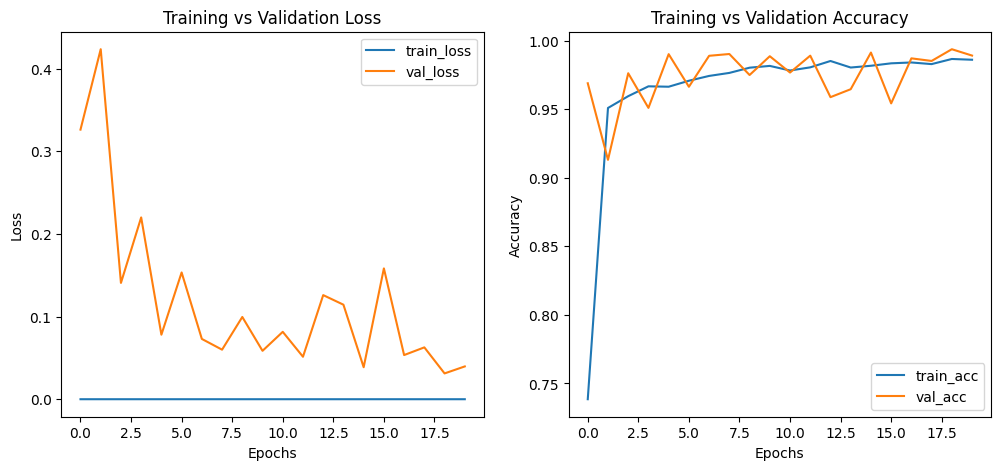

In [14]:
import matplotlib.pyplot as plt

# 학습 기록 불러오기
history_dict = history.history

# loss 그래프
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history_dict["loss"], label="train_loss")
plt.plot(history_dict["val_loss"], label="val_loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()

# accuracy 그래프
plt.subplot(1, 2, 2)
plt.plot(history_dict["accuracy"], label="train_acc")
plt.plot(history_dict["val_accuracy"], label="val_acc")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()

plt.show()


## Train the model with `class_weight` argument

## Conclusions

At the end of training, out of 56,961 validation transactions, we are:

- Correctly identifying 66 of them as fraudulent
- Missing 9 fraudulent transactions
- At the cost of incorrectly flagging 441 legitimate transactions

In the real world, one would put an even higher weight on class 1,
so as to reflect that False Negatives are more costly than False Positives.

Next time your credit card gets  declined in an online purchase -- this is why.

